In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [4]:
def value_function_ap(state, agent):
    assert agent.compiled == True
    state_ = np.array([[state]])
    action_ = agent.actor.predict(state_)
    value_function = agent.critic.predict([action_, state_])[0][0] #Q(a,s)
    return value_function

def value_function(state, agent, step_limit=5000):
    gamma = 0.99
    env.reset()
    env.set_state = state
    episode_reward = 0
    for steps in range(step_limit):
        reward = 0
        x = env.state
        a_agent, tau = agent.forward(x)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
        dt = tau / action_repetition
        for p in range(action_repetition):
            _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - tau * 0.01 * a_agent**2 + l * tau # step reward

        episode_reward += pow(gamma, steps) * reward
    return episode_reward

In [5]:
# agent compilation
l = 1.
step = 50000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

## 0.01に張り付くagentか, self_triggerっぽいagentかどちらかに学習できるか, 学習が発散するかのどれかになる
学習できた二つについて,  $J(\theta)$の値がどちらが大きいのかを調べる

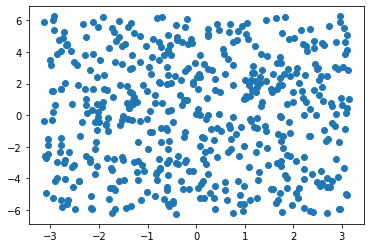

In [6]:
# sample state
lim = np.array([np.pi, 2*np.pi])
state_batch = []
batch_size = 500

for _ in range(batch_size):
    state_batch.append(np.random.uniform(low=-lim, high=lim))
state_batch = np.array(state_batch)

plt.scatter(state_batch[:,0], state_batch[:,1])

## 0.01に張り付くagent

In [27]:
# agent setup
a.load_weights('./saved_agent/learned_from_001.h5')
a.training = False

In [28]:
# critic由来のVと, 蓄積リワードをそれぞれ調べる(全然違う疑惑があるから)

v_aps_001 = []
vs_001 = []

for i, state in enumerate(state_batch):
    print(f'{int(i/5)}%\r',end='')
    v_aps_001.append(value_function_ap(state, a))
    vs_001.append(value_function(state, a))

In [29]:
# evaluation function

print(f'J(theta) with reward: {np.average(vs_001)}')
print(f'J(theta) with critic: {np.average(v_aps_001)}')

J(theta) with reward: 0.7500236001079005
J(theta) with critic: 1.0748480558395386


## いい感じのagent

In [30]:
# agent setup
a.load_weights('./saved_agent/learned_self4.h5')
a.training = False

In [31]:
# critic由来のVと, 蓄積リワードをそれぞれ調べる(全然違う疑惑があるから)

v_aps = []
vs = []

for i, state in enumerate(state_batch):
    print(f'{int(i/5)}%\r',end='')
    v_aps.append(value_function_ap(state, a))
    vs.append(value_function(state, a))

In [32]:
# evaluation function

print(f'J(theta) with reward: {np.average(vs)}')
print(f'J(theta) with critic: {np.average(v_aps)}')

J(theta) with reward: 33.81102331765953
J(theta) with critic: 10.565957069396973


In [39]:
# data save

In [38]:
with open('./csv/v_aps_001.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(np.array(v_aps_001))
    
with open('./csv/vs_001.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(np.array(vs_001))
    
with open('./csv/v_aps.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(np.array(v_aps))
    
with open('./csv/vs.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(np.array(vs))
    
with open('./csv/state_batch.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(state_batch)